# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a prospect will churn or not.


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Step 1: Load Data

Dropping HasCrCard variable since it did not correlate significantly with churned customers

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank_customer_churn.csv")
      .drop(labels=['RowNumber', 'CustomerId', 'Surname','HasCrCard'], axis=1)  
                    # target variable for regressor, remove from classifier  
                    # drop other variables we will not need for this project
  )

# Standardize tenure with age
df['TenureByAge'] = df['Tenure']/df['Age']
obj_vars = ['Geography',
            'Gender',  
            'IsActiveMember',
            ]
df[obj_vars] = df[obj_vars].astype(object)


print(df.shape)
print(df.dtypes)
print(df.nunique())
df.head(3)


(10000, 11)
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
IsActiveMember      object
EstimatedSalary    float64
Exited               int64
TenureByAge        float64
dtype: object
CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
IsActiveMember        2
EstimatedSalary    9999
Exited                2
TenureByAge         414
dtype: int64


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,TenureByAge
0,619,France,1,42,2,0.00,1,1,101348.88,1,0.047619
1,608,Spain,1,41,1,83807.86,1,1,112542.58,0,0.024390
2,502,France,1,42,8,159660.80,3,0,113931.57,1,0.190476


In [5]:
robust_scaled_vars = ['Age','Balance','CreditScore','EstimatedSalary','TenureByAge']

---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=[
            'Age',
         'CreditScore'
        ])),
        ("PowerTransformer", vt.PowerTransformer(variables='TenureByAge')),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=[
            'Gender',
            'Geography',
            'IsActiveMember',            
            ])),
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore'])),
                ('PowerTransformer', PowerTransformer(variables='TenureByAge')),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography',
                                           'IsActiveMember']))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def PipelineClf(model):
    pipeline_base = Pipeline([
        ('robust_scaler', RobustScaler(robust_scaled_vars)),
        ('standard_scaler', StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


RobustScaler picked as scaler as it performs better with outliers

Custom Class for Hyperparameter Optimisation

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            param_grid = self.params[key]
            gs = GridSearchCV(model, param_grid, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.3,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(7000, 10) (7000,) (3000, 10) (3000,)


## Handle Target Imbalance

In [10]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7000, 10) (7000,) (3000, 10) (3000,)


Check Train Set Target distribution

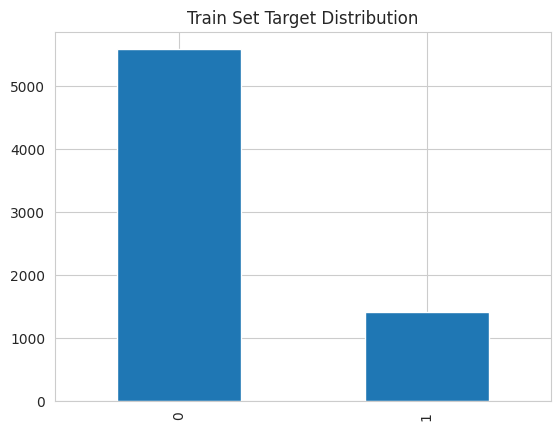

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [12]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11168, 10) (11168,) (3000, 10) (3000,)


Check Train Set Target distribution after resampling

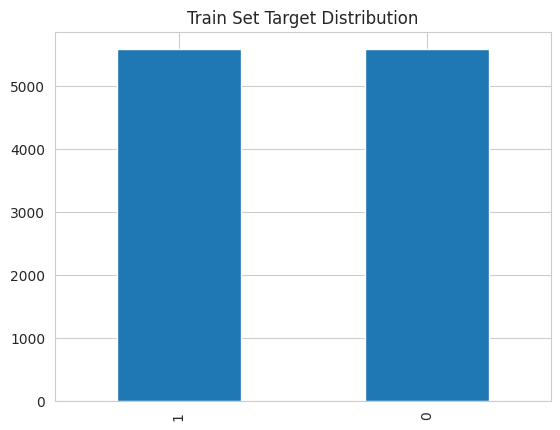

In [13]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [15]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,ExtraTreesClassifier,0.77171,0.863009,0.905914,0.050302
3,RandomForestClassifier,0.632945,0.839915,0.926523,0.108238
4,GradientBoostingClassifier,0.518353,0.801774,0.909498,0.146165
1,XGBClassifier,0.159355,0.782088,0.980304,0.316132
2,DecisionTreeClassifier,0.098478,0.743768,0.946237,0.324567
6,AdaBoostClassifier,0.589973,0.706315,0.767921,0.063625
0,LogisticRegression,0.581021,0.705953,0.766338,0.068707


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [17]:
models_search = {
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
}

# models_search = ExtraTreesClassifier(random_state=0)
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

params_search = {'ExtraTreesClassifier': {
    'model__n_estimators': [78], # Number of trees
    'model__max_features': ['auto'], # Max features at split
    'model__max_depth': [4], # Max depth of trees, More depth risks Overfitting
    'model__min_samples_split': [2], # Min samples to split node, decreasing can help model capture the minority class
    'model__min_samples_leaf': [24], # Min samples at leaf node
    'model__bootstrap': [False] # Bootstrap samples for trees}
}
}


clf = ExtraTreesClassifier()
params = clf.get_params()
available_params = params.keys()
print(available_params)


dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


Extensive GridSearch CV - Binary Classifier

In [18]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)

search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5
           )
    


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [19]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesClassifier,0.757386,0.792805,0.825425,0.027201,False,4,auto,24,2,78


Get best model name programmatically

In [20]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

Parameters for best model

In [21]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__bootstrap': False,
 'model__max_depth': 4,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 24,
 'model__min_samples_split': 2,
 'model__n_estimators': 78}

Define the best clf pipeline

In [22]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary',
                                              'TenureByAge'])),
                ('standard_scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_depth=4, min_samples_leaf=24,
                                      n_estimators=78, random_state=0))])

## Assess feature importance

In [23]:
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,TenureByAge
0,1390.723765,0,0,2.234510,2,146193.60,2,0,55796.83,0.246183
1,1146.454875,0,0,2.293289,7,0.00,2,1,19823.02,0.423659
2,1265.424061,0,1,2.504660,5,160979.68,1,0,13848.58,0.256495


* With the current model, we can assess with `.features_importances_`

* These are the 6 most important features in descending order. The model was trained on them: 
['Age', 'NumOfProducts', 'TenureByAge', 'Balance', 'CreditScore', 'EstimatedSalary']


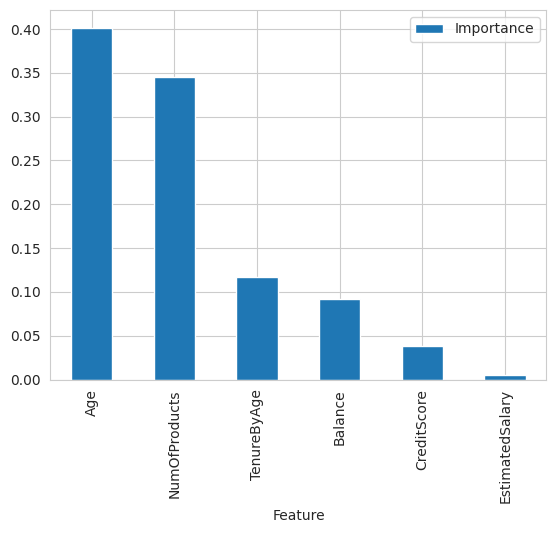

In [24]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [26]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            3881         1129
Prediction Churn               1703         4455


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.77      0.70      0.73      5584
       Churn       0.72      0.80      0.76      5584

    accuracy                           0.75     11168
   macro avg       0.75      0.75      0.75     11168
weighted avg       0.75      0.75      0.75     11168
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            1591          129
Prediction Churn                788          492


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.93      0.67      0.78      2379
       Churn       0.38      0.79      0.52       621

    accuracy                           0.69      

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [27]:
best_features

['Age',
 'NumOfProducts',
 'TenureByAge',
 'Balance',
 'CreditScore',
 'EstimatedSalary']

New Pipeline for DataCleaning And FeatureEngineering

In [47]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("YeoJohnson", vt.YeoJohnsonTransformer(variables=['Age','CreditScore'])),
        # ("Power", vt.PowerTransformer(variables=['TenureByAge'])),
        #  ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=[
        #     'Gender',
        #     'Geography',
        #     'IsActiveMember',            
        #     ])),
        # we don't need SmartCorrelatedSelection or Ordinal Encoding
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [48]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
         ('robust_scaler', RobustScaler(robust_scaled_vars)),
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Exited'], axis=1),
    df['Exited'],
    test_size=0.3,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(7000, 10) (7000,) (3000, 10) (3000,)


We filter only the most important variables

In [50]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(7000, 6) (7000,) (3000, 6) (3000,)


,Age,NumOfProducts,TenureByAge,Balance,CreditScore,EstimatedSalary
7681,33,2,0.060606,146193.60,641,55796.83
9031,39,2,0.179487,0.00,541,19823.02
3691,76,1,0.065789,160979.68,590,13848.58


## Handle Target Imbalance

In [51]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7000, 6) (7000,) (3000, 6) (3000,)


Check Train Set Target distribution

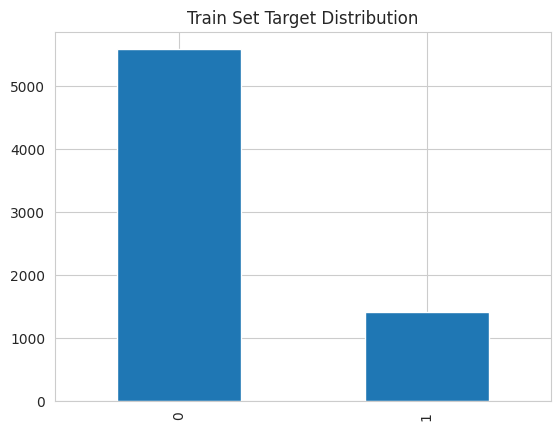

In [52]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [53]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11168, 6) (11168,) (3000, 6) (3000,)


Check Train Set Target distribution after SMOTE

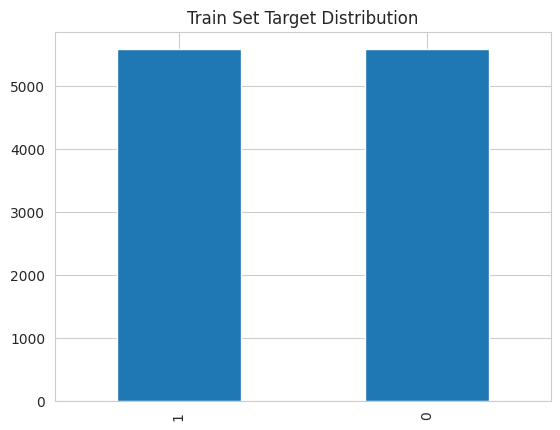

In [54]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [55]:
models_search   # ExtraTreesClassifier

{'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)}

And the best parameters from the last GridCV search 

In [56]:
best_parameters

{'model__bootstrap': False,
 'model__max_depth': 4,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 24,
 'model__min_samples_split': 2,
 'model__n_estimators': 78}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [57]:
params_search = {'ExtraTreesClassifier':  {
 'model__bootstrap': [False],
 'model__max_depth': [4],
 'model__max_features': ['auto'],
 'model__min_samples_leaf': [24],
 'model__min_samples_split': [2],
 'model__n_estimators': [78]
   
}}
params_search


{'ExtraTreesClassifier': {'model__bootstrap': [False],
  'model__max_depth': [4],
  'model__max_features': ['auto'],
  'model__min_samples_leaf': [24],
  'model__min_samples_split': [2],
  'model__n_estimators': [78]}}

GridSearch CV

In [58]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)



Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass with_centering=['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'TenureByAge'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Check results

In [59]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesClassifier,0.758281,0.793162,0.829006,0.026735,False,4,auto,24,2,78


Define the best clf pipeline

In [60]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary',
                                              'TenureByAge'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(max_depth=4, min_samples_leaf=24,
                                      n_estimators=78, random_state=0))])

## Assess feature importance

* These are the 6 most important features in descending order. The model was trained on them: 
['NumOfProducts', 'Age', 'TenureByAge', 'Balance', 'CreditScore', 'EstimatedSalary']


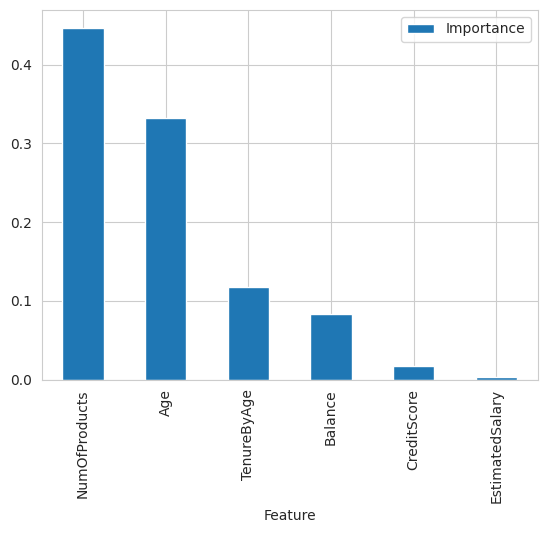

In [61]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [62]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            3717         1114
Prediction Churn               1867         4470


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.77      0.67      0.71      5584
       Churn       0.71      0.80      0.75      5584

    accuracy                           0.73     11168
   macro avg       0.74      0.73      0.73     11168
weighted avg       0.74      0.73      0.73     11168
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual No Churn Actual Churn
Prediction No Churn            1517          124
Prediction Churn                862          497


---  Classification Report  ---
              precision    recall  f1-score   support

    No Churn       0.92      0.64      0.75      2379
       Churn       0.37      0.80      0.50       621

    accuracy                           0.67      

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [46]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_churn/v1'


## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

In [63]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [64]:
y_train

0        1
1        0
2        0
3        1
4        0
        ..
11163    1
11164    1
11165    1
11166    1
11167    1
Name: Exited, Length: 11168, dtype: int64

In [65]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [66]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [67]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [68]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('YeoJohnson',
                 YeoJohnsonTransformer(variables=['Age', 'CreditScore']))])

In [69]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_churn/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

* Pipeline responsible for Feature Scaling, and Model

In [70]:
pipeline_clf

Pipeline(steps=[('robust_scaler',
                 RobustScaler(with_centering=['Age', 'Balance', 'CreditScore',
                                              'EstimatedSalary',
                                              'TenureByAge'])),
                ('scaler', StandardScaler()),
                ('model',
                 ExtraTreesClassifier(max_depth=4, min_samples_leaf=24,
                                      n_estimators=78, random_state=0))])

In [71]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_churn/v1/clf_pipeline_model.pkl']

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

In [ ]:
df.head(3)

---